In [2]:
#Mounting my google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
#Verifying the dataset
import os
for root, _, files in os.walk('/content/drive/MyDrive/ravdess 1-24'):
    print(f"Folder: {root}, Files: {len([f for f in files if f.endswith('.wav')])}")

Folder: /content/drive/MyDrive/ravdess 1-24, Files: 0
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_22, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_24, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_15, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_18, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_17, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_21, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_16, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_19, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_20, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_23, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_11, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_06, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_09, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_13, Files: 60
Folder: /content/drive/MyDrive/ravdess 1-24/Actor_

In [19]:
# Installing dependencies
!pip install librosa numpy pandas scikit-learn tensorflow matplotlib seaborn

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence, to_categorical
import tensorflow as tf
import pickle

In [5]:
#Verifying GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)


Num GPUs Available:  1
GPU memory growth enabled


In [21]:
# Data generator

class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, n_mfcc=13, n_mels=40, max_len=100, augment=False, model_type='cnn'):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.max_len = max_len
        self.augment = augment
        self.model_type = model_type
        self.label_encoder = LabelEncoder()
        self.labels_encoded = to_categorical(self.label_encoder.fit_transform(labels))

        self.num_classes = self.labels_encoded.shape[1]

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels_encoded[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X = []
        batch_y = []
        for file_path, label in zip(batch_files, batch_labels):
            try:
                audio, sr = librosa.load(file_path, sr=22050)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.n_mfcc)
                delta_mfcc = librosa.feature.delta(mfcc)
                mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=self.n_mels)
                mel = librosa.power_to_db(mel)
                if mfcc.shape[1] > self.max_len:
                    mfcc = mfcc[:, :self.max_len]
                    delta_mfcc = delta_mfcc[:, :self.max_len]
                    mel = mel[:, :self.max_len]
                else:
                    pad_width = self.max_len - mfcc.shape[1]
                    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                    delta_mfcc = np.pad(delta_mfcc, ((0, 0), (0, pad_width)), mode='constant')
                    mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
                mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
                delta_mfcc = (delta_mfcc - np.mean(delta_mfcc)) / np.std(delta_mfcc)
                mel = (mel - np.mean(mel)) / np.std(mel)
                features = np.concatenate([mfcc, delta_mfcc, mel], axis=0)
                batch_X.append(features)
                batch_y.append(label)
                if self.augment:
                    noise = np.random.normal(0, 0.005, audio.shape)
                    audio_aug = audio + noise
                    mfcc_aug = librosa.feature.mfcc(y=audio_aug, sr=sr, n_mfcc=self.n_mfcc)
                    delta_mfcc_aug = librosa.feature.delta(mfcc_aug)
                    mel_aug = librosa.feature.melspectrogram(y=audio_aug, sr=sr, n_mels=self.n_mels)
                    mel_aug = librosa.power_to_db(mel_aug)
                    if mfcc_aug.shape[1] > self.max_len:
                        mfcc_aug = mfcc_aug[:, :self.max_len]
                        delta_mfcc_aug = delta_mfcc_aug[:, :self.max_len]
                        mel_aug = mel_aug[:, :self.max_len]
                    else:
                        pad_width = self.max_len - mfcc_aug.shape[1]
                        mfcc_aug = np.pad(mfcc_aug, ((0, 0), (0, pad_width)), mode='constant')
                        delta_mfcc_aug = np.pad(delta_mfcc_aug, ((0, 0), (0, pad_width)), mode='constant')
                        mel_aug = np.pad(mel_aug, ((0, 0), (0, pad_width)), mode='constant')
                    mfcc_aug = (mfcc_aug - np.mean(mfcc_aug)) / np.std(mfcc_aug)
                    delta_mfcc_aug = (delta_mfcc_aug - np.mean(delta_mfcc_aug)) / np.std(delta_mfcc_aug)
                    mel_aug = (mel_aug - np.mean(mel_aug)) / np.std(mel_aug)
                    features_aug = np.concatenate([mfcc_aug, delta_mfcc_aug, mel_aug], axis=0)
                    batch_X.append(features_aug)
                    batch_y.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

        if self.model_type == 'cnn':
            batch_X = np.array(batch_X).reshape(-1, 66, self.max_len, 1)
        else:
            batch_X = np.array(batch_X)
        batch_y = np.array(batch_y)
        return batch_X, batch_y


    def get_output_signature(self):
        if self.model_type == 'cnn':
            input_shape = (None, 66, self.max_len, 1)
        else:
            input_shape = (None, 66, self.max_len)
        return (
            tf.TensorSpec(shape=input_shape, dtype=tf.float32),
            tf.TensorSpec(shape=(None, self.num_classes), dtype=tf.float32)
        )

In [22]:
#Loading RAVDESS Dataset
def load_ravdess_data(data_path):
    files = []
    emotions = []
    actors = []
    emotion_dict = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    for root, _, filenames in os.walk(data_path):
        for file in filenames:
            if file.lower().endswith('.wav'):
                file_path = os.path.join(root, file).replace('\\', '/')
                file_identifiers = file.split('.')[0].split('-')
                if len(file_identifiers) >= 7:
                    emotion_code = file_identifiers[2]
                    actor_code = file_identifiers[6]
                    if emotion_code in emotion_dict:
                        files.append(file_path)
                        emotions.append(emotion_dict[emotion_code])
                        actors.append(actor_code.zfill(2))
                    else:
                        print(f"Invalid emotion code {emotion_code} in {file_path}")
                else:
                    print(f"Invalid filename format in {file_path}")
    if not files:
        print(f"Error: No .wav files found in {data_path}. Check dataset path and file structure.")
        return [], [], []
    print(f"Loaded {len(files)} files")
    print(f"Unique emotions: {set(emotions)}")
    print(f"Sample files (first 5): {files[:5]}")
    print(f"Sample emotions (first 5): {emotions[:5]}")
    print(f"Sample actors (first 5): {actors[:5]}")
    return files, emotions, actors

data_path = '/content/drive/MyDrive/ravdess 1-24'
files, emotions, actors = load_ravdess_data(data_path)


Loaded 1440 files
Unique emotions: {'sad', 'fearful', 'calm', 'angry', 'surprised', 'neutral', 'happy', 'disgust'}
Sample files (first 5): ['/content/drive/MyDrive/ravdess 1-24/Actor_22/03-01-04-01-02-01-22.wav', '/content/drive/MyDrive/ravdess 1-24/Actor_22/03-01-02-01-01-02-22.wav', '/content/drive/MyDrive/ravdess 1-24/Actor_22/03-01-02-02-02-01-22.wav', '/content/drive/MyDrive/ravdess 1-24/Actor_22/03-01-01-01-01-01-22.wav', '/content/drive/MyDrive/ravdess 1-24/Actor_22/03-01-04-01-01-01-22.wav']
Sample emotions (first 5): ['sad', 'calm', 'calm', 'neutral', 'sad']
Sample actors (first 5): ['22', '22', '22', '22', '22']


In [23]:
#Spliting Data
def split_data(files, emotions, actors):
    train_files = [f for f, a in zip(files, actors) if a not in ['06', '24']]
    train_emotions = [e for e, a in zip(emotions, actors) if a not in ['06', '24']]
    val_files = [f for f, a in zip(files, actors) if a == '06']
    val_emotions = [e for e, a in zip(emotions, actors) if a == '06']
    test_files = [f for f, a in zip(files, actors) if a == '24']
    test_emotions = [e for e, a in zip(emotions, actors) if a == '24']
    if not val_files or not test_files:
        print(f"Error: Validation files ({len(val_files)}) or test files ({len(test_files)}) empty. Check actor codes.")
        print(f"Available actors: {set(actors)}")
        return [], [], [], [], [], []
    print(f"Training files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")
    print(f"Sample test files (first 3): {test_files[:3]}")
    print(f"Sample test emotions (first 3): {test_emotions[:3]}")
    return train_files, train_emotions, val_files, val_emotions, test_files, test_emotions

train_files, train_emotions, val_files, val_emotions, test_files, test_emotions = split_data(files, emotions, actors)

Training files: 1320, Validation files: 60, Test files: 60
Sample test files (first 3): ['/content/drive/MyDrive/ravdess 1-24/Actor_24/03-01-04-02-01-02-24.wav', '/content/drive/MyDrive/ravdess 1-24/Actor_24/03-01-06-01-01-02-24.wav', '/content/drive/MyDrive/ravdess 1-24/Actor_24/03-01-07-02-01-01-24.wav']
Sample test emotions (first 3): ['sad', 'fearful', 'disgust']


In [24]:
#Extract Features for Validation and Test Sets
def extract_features(files, emotions):
    X = []
    y = []
    label_encoder = LabelEncoder()
    for file_path, emotion in zip(files, emotions):
        try:
            audio, sr = librosa.load(file_path, sr=22050)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            delta_mfcc = librosa.feature.delta(mfcc)
            mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40)
            mel = librosa.power_to_db(mel)
            if mfcc.shape[1] > 100:
                mfcc = mfcc[:, :100]
                delta_mfcc = delta_mfcc[:, :100]
                mel = mel[:, :100]
            else:
                pad_width = 100 - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
                delta_mfcc = np.pad(delta_mfcc, ((0, 0), (0, pad_width)), mode='constant')
                mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
            mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
            delta_mfcc = (delta_mfcc - np.mean(delta_mfcc)) / np.std(delta_mfcc)
            mel = (mel - np.mean(mel)) / np.std(mel)
            features = np.concatenate([mfcc, delta_mfcc, mel], axis=0)
            X.append(features)
            y.append(emotion)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    X_cnn = np.array(X).reshape(-1, 66, 100, 1)
    X_lstm = np.array(X)
    print(f"Feature shapes: X_cnn {X_cnn.shape}, X_lstm {X_lstm.shape}, y {y_categorical.shape}")
    print(f"Classes: {label_encoder.classes_}")
    return X_cnn, X_lstm, y_categorical, label_encoder

X_val_cnn, X_val_lstm, y_val, label_encoder = extract_features(val_files, val_emotions)
X_test_cnn, X_test_lstm, y_test, _ = extract_features(test_files, test_emotions)

Feature shapes: X_cnn (60, 66, 100, 1), X_lstm (60, 66, 100), y (60, 8)
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Feature shapes: X_cnn (60, 66, 100, 1), X_lstm (60, 66, 100), y (60, 8)
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [25]:
#Preparing Training Data Generator
def prepare_train_generator(train_files, train_emotions):

    cnn_generator = AudioDataGenerator(train_files, train_emotions, batch_size=64, augment=True, model_type='cnn')
    lstm_generator = AudioDataGenerator(train_files, train_emotions, batch_size=64, augment=True, model_type='lstm')
    print(f"Training batches (CNN): {len(cnn_generator)}, (LSTM): {len(lstm_generator)}")
    return cnn_generator, lstm_generator

cnn_generator, lstm_generator = prepare_train_generator(train_files, train_emotions)

Training batches (CNN): 21, (LSTM): 21


In [26]:
#Compute Class Weights
def compute_class_weights(train_emotions, label_encoder):
    y_encoded = label_encoder.fit_transform(train_emotions)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
    class_weight_dict = dict(enumerate(class_weights))
    print("Class distribution:", Counter(train_emotions))
    print("Class weights:", class_weight_dict)
    return class_weight_dict

class_weight_dict = compute_class_weights(train_emotions, label_encoder)


Class distribution: Counter({'sad': 176, 'calm': 176, 'happy': 176, 'fearful': 176, 'angry': 176, 'disgust': 176, 'surprised': 176, 'neutral': 88})
Class weights: {0: np.float64(0.9375), 1: np.float64(0.9375), 2: np.float64(0.9375), 3: np.float64(0.9375), 4: np.float64(0.9375), 5: np.float64(1.875), 6: np.float64(0.9375), 7: np.float64(0.9375)}


In [27]:
#Building CNN Model
def build_cnn_model(input_shape, num_classes):
    cnn_model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("CNN model summary:")
    cnn_model.summary()
    return cnn_model

cnn_model = build_cnn_model(input_shape=(66, 100, 1), num_classes=y_val.shape[1])

CNN model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 66, 100, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 33, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,657,800 (6.32 MB)

 Trainable params: 1,657,800 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#Training CNN Model
def train_cnn_model(cnn_model, cnn_generator, X_val_cnn, y_val, class_weight_dict):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    print("Training CNN started")

    cnn_history = cnn_model.fit(
        cnn_generator,
        epochs=20,
        validation_data=(X_val_cnn, y_val),
        verbose=0,
        callbacks=[early_stopping],
        class_weight=class_weight_dict
    )
    print("Training CNN completed")
    return cnn_history

cnn_history = train_cnn_model(cnn_model, cnn_generator, X_val_cnn, y_val, class_weight_dict)

Training CNN started


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training CNN completed


Evaluating CNN model...
CNN Validation Accuracy: 41.67%
CNN Validation Classification Report:
              precision    recall  f1-score   support

       angry       0.88      0.88      0.88         8
        calm       0.50      0.50      0.50         8
     disgust       0.30      0.38      0.33         8
     fearful       0.16      0.38      0.22         8
       happy       0.67      0.25      0.36         8
     neutral       0.40      0.50      0.44         4
         sad       0.80      0.50      0.62         8
   surprised       0.00      0.00      0.00         8

    accuracy                           0.42        60
   macro avg       0.46      0.42      0.42        60
weighted avg       0.47      0.42      0.42        60



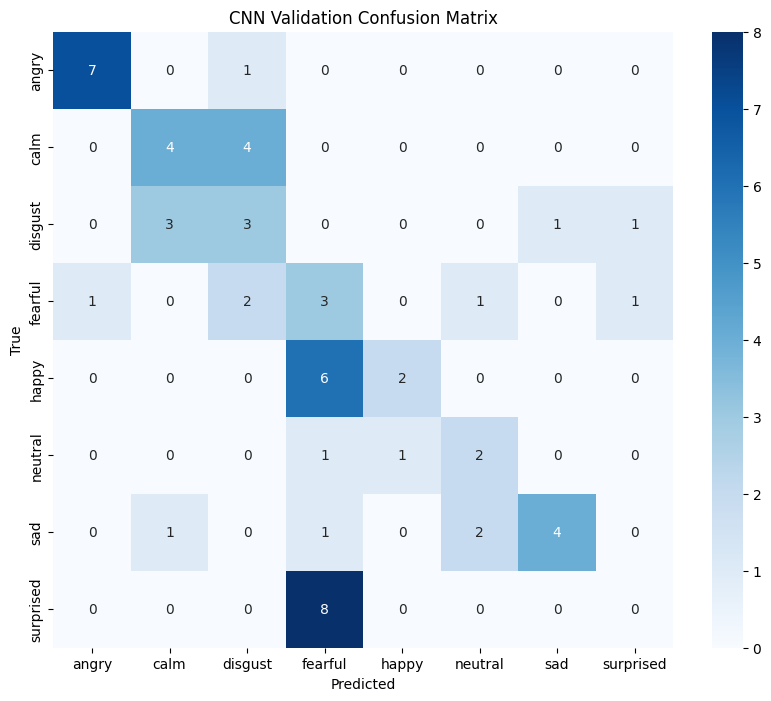

In [29]:
#Validating CNN Model
def validate_cnn_model(cnn_model, X_val_cnn, y_val, label_encoder):
    print("Evaluating CNN model...")
    cnn_loss, cnn_accuracy = cnn_model.evaluate(X_val_cnn, y_val, verbose=0)
    print(f"CNN Validation Accuracy: {cnn_accuracy*100:.2f}%")
    y_pred_cnn = cnn_model.predict(X_val_cnn, verbose=0)
    print("CNN Validation Classification Report:")
    print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_cnn, axis=1), target_names=label_encoder.classes_))
    cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred_cnn, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('CNN Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return cnn_accuracy, y_pred_cnn

cnn_accuracy, y_pred_cnn = validate_cnn_model(cnn_model, X_val_cnn, y_val, label_encoder)

In [30]:
#Building LSTM Model
def build_lstm_model(input_shape, num_classes):
    lstm_model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("LSTM model summary:")
    lstm_model.summary()
    return lstm_model

lstm_model = build_lstm_model(input_shape=(66, 100), num_classes=y_val.shape[1])


LSTM model summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 66, 128)        │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,336 (669.28 KB)

 Trainable params: 171,336 (669.28 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
#Training LSTM Model
def train_lstm_model(lstm_model, lstm_generator, X_val_lstm, y_val, class_weight_dict):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    print("Training LSTM started")

    lstm_history = lstm_model.fit(
        lstm_generator,
        epochs=20,
        validation_data=(X_val_lstm, y_val),
        verbose=0,
        callbacks=[early_stopping],
        class_weight=class_weight_dict
    )
    print("Training LSTM completed")
    return lstm_history

lstm_history = train_lstm_model(lstm_model, lstm_generator, X_val_lstm, y_val, class_weight_dict)

Training LSTM started


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training LSTM completed


Evaluating LSTM model...
LSTM Validation Accuracy: 35.00%
LSTM Validation Classification Report:
              precision    recall  f1-score   support

       angry       0.67      0.50      0.57         8
        calm       0.50      0.50      0.50         8
     disgust       0.33      0.50      0.40         8
     fearful       0.14      0.25      0.18         8
       happy       0.33      0.12      0.18         8
     neutral       0.25      0.50      0.33         4
         sad       0.40      0.25      0.31         8
   surprised       0.50      0.25      0.33         8

    accuracy                           0.35        60
   macro avg       0.39      0.36      0.35        60
weighted avg       0.40      0.35      0.35        60



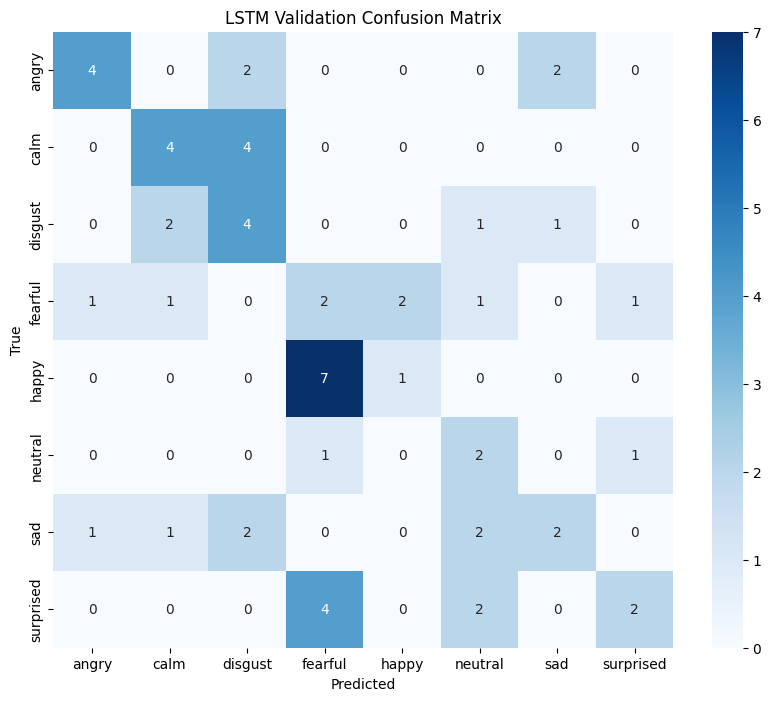

In [32]:
 #Validating LSTM Model
def validate_lstm_model(lstm_model, X_val_lstm, y_val, label_encoder):
    print("Evaluating LSTM model...")
    lstm_loss, lstm_accuracy = lstm_model.evaluate(X_val_lstm, y_val, verbose=0)
    print(f"LSTM Validation Accuracy: {lstm_accuracy*100:.2f}%")
    y_pred_lstm = lstm_model.predict(X_val_lstm, verbose=0)
    print("LSTM Validation Classification Report:")
    print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_pred_lstm, axis=1), target_names=label_encoder.classes_))
    cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred_lstm, axis=1))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('LSTM Validation Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return lstm_accuracy, y_pred_lstm

lstm_accuracy, y_pred_lstm = validate_lstm_model(lstm_model, X_val_lstm, y_val, label_encoder)

In [33]:
#Selecting Best Model
def select_best_model(cnn_accuracy, lstm_accuracy, cnn_model, lstm_model):
    if cnn_accuracy >= lstm_accuracy - 0.05:
        best_model = cnn_model
        best_accuracy = cnn_accuracy
        model_name = "CNN"
    else:
        best_model = lstm_model
        best_accuracy = lstm_accuracy
        model_name = "LSTM"
    print(f"Selected {model_name} model with accuracy: {best_accuracy*100:.2f}%")
    best_model.save('/content/drive/MyDrive/emotion_recognition_best_model.h5')
    print("Best model saved.")
    return best_model, model_name

best_model, model_name = select_best_model(cnn_accuracy, lstm_accuracy, cnn_model, lstm_model)


Selected CNN model with accuracy: 41.67%
Best model saved.


In [34]:
#Testing New Sample
def test_new_sample(sample_file, best_model, label_encoder, true_emotion, is_cnn=True):
    try:
        audio, sr = librosa.load(sample_file, sr=22050)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        delta_mfcc = librosa.feature.delta(mfcc)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40)
        mel = librosa.power_to_db(mel)
        if mfcc.shape[1] > 100:
            mfcc = mfcc[:, :100]
            delta_mfcc = delta_mfcc[:, :100]
            mel = mel[:, :100]
        else:
            pad_width = 100 - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            delta_mfcc = np.pad(delta_mfcc, ((0, 0), (0, pad_width)), mode='constant')
            mel = np.pad(mel, ((0, 0), (0, pad_width)), mode='constant')
        mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
        delta_mfcc = (delta_mfcc - np.mean(delta_mfcc)) / np.std(delta_mfcc)
        mel = (mel - np.mean(mel)) / np.std(mel)
        features = np.concatenate([mfcc, delta_mfcc, mel], axis=0)
        if is_cnn:
            features = features.reshape(1, 66, 100, 1)
        else:
            features = features.reshape(1, 66, 100)
        pred = best_model.predict(features, verbose=0)
        emotion = label_encoder.inverse_transform([np.argmax(pred[0])])[0]
        print(f"Sample: {sample_file}")
        print(f"True Emotion: {true_emotion}")
        print(f"{model_name} Predicted Emotion: {emotion}")
    except Exception as e:
        print(f"Error testing sample {sample_file}: {e}")

sample_file = '/content/drive/MyDrive/ravdess 1-24/Actor_24/03-01-05-01-01-01-24.wav'
true_emotion = 'angry'
test_new_sample(sample_file, best_model, label_encoder, true_emotion, is_cnn=(model_name == "CNN"))


Sample: /content/drive/MyDrive/ravdess 1-24/Actor_24/03-01-05-01-01-01-24.wav
True Emotion: angry
CNN Predicted Emotion: angry
